In [1]:
import sys
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import subtle.subtle_io as suio
import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
sys.path.insert(0, '/home/subtle/jon/tools/SimpleElastix/build/SimpleITK-build/Wrapping/Python/Packaging/build/lib.linux-x86_64-3.5/SimpleITK')
import SimpleITK as sitk

Using TensorFlow backend.


In [24]:
base_path = '/home/subtle/Data/Stanford/lowcon/Patient_0217'
path_zero, path_low, path_full = suio.get_dicom_dirs(base_path)
print(path_zero)
print(path_low)
print(path_full)

/home/subtle/Data/Stanford/lowcon/Patient_0217/8_AX_BRAVO
/home/subtle/Data/Stanford/lowcon/Patient_0217/11_AX_BRAVO_+C_pre_load_10%
/home/subtle/Data/Stanford/lowcon/Patient_0217/14_AX_BRAVO_+C


In [16]:
ims_zero, hdr_zero = suio.dicom_files(path_zero, normalize=False)
ims_low, hdr_low = suio.dicom_files(path_low, normalize=False)
ims_full, hdr_full = suio.dicom_files(path_full, normalize=False)

In [17]:
pixel_spacing_zero = suio.get_pixel_spacing(hdr_zero)
pixel_spacing_low = suio.get_pixel_spacing(hdr_low)
pixel_spacing_full = suio.get_pixel_spacing(hdr_full)

In [18]:
ims = np.stack((ims_zero, ims_low, ims_full), axis=1)

In [19]:
mask = sup.mask_im(ims, threshold=.03)
print(mask.shape)

(178, 3, 512, 512)


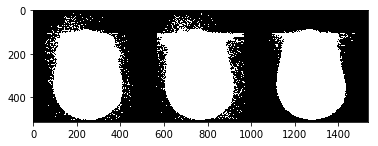

In [20]:
suplot.imshowtile(mask[100,...].squeeze().transpose((1,2,0)))

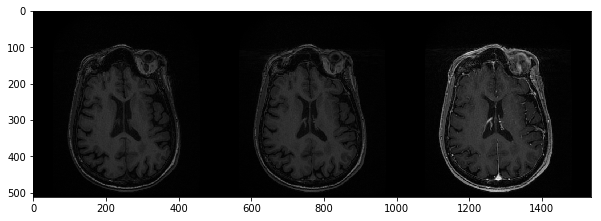

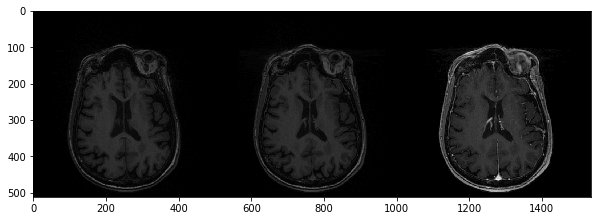

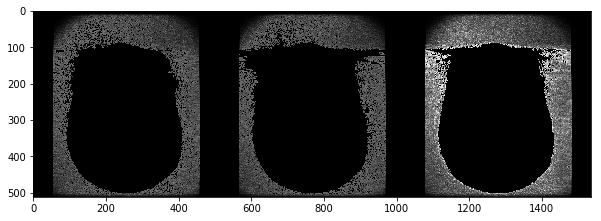

In [21]:
ims_masked = ims * mask
plt.figure(figsize=(10,8))
suplot.imshowtile(ims[100,...].squeeze().transpose((1,2,0)))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked[100,...].squeeze().transpose((1,2,0)))

plt.figure(figsize=(10,8))
suplot.imshowtile(abs(ims-ims_masked)[100,...].squeeze().transpose((1,2,0)))

In [22]:
levels = 1024
points = 50
mean_intensity = True
ims_masked_scaled = ims.copy()
ims_masked_scaled[:,1,:,:] = sup.scale_im(ims_masked[:,0,:,:], ims_masked[:,1,:,:], levels, points, mean_intensity)
ims_masked_scaled[:,2,:,:] = sup.scale_im(ims_masked[:,0,:,:], ims_masked[:,2,:,:], levels, points, mean_intensity)


image intensity normalization
scaling done, 3.75 s
image intensity normalization
scaling done, 3.97 s


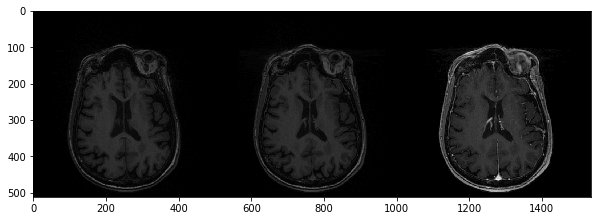

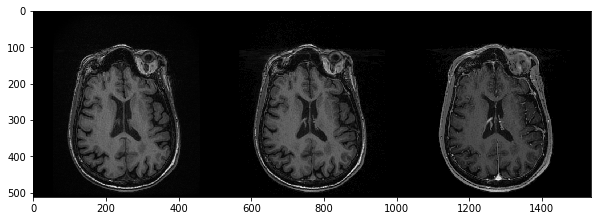

In [23]:
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked[100,...].squeeze().transpose((1,2,0)))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked_scaled[100,...].squeeze().transpose((1,2,0)))


### check registration with and without histogram normalization
doesn't seem to matter

image registration
registration done, 21.8 s
image registration
registration done, 21.3 s


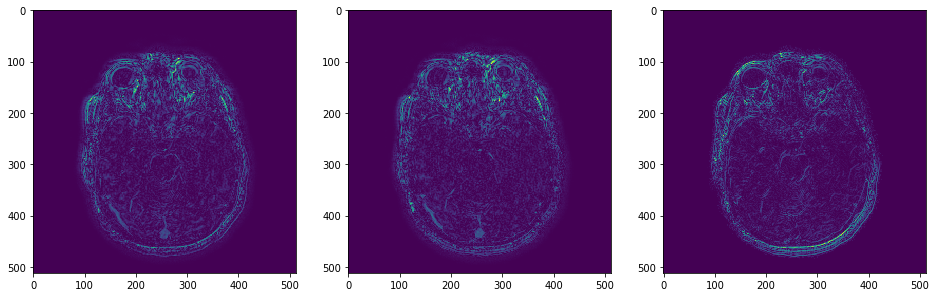

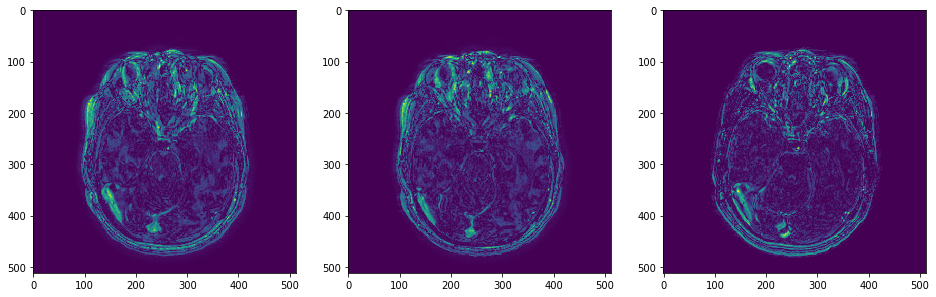

In [13]:
# registration without mask
spars = sitk.GetDefaultParameterMap('rigid')
im_low_reg, spars_low_out = sup.register_im(ims_masked_scaled[:,0,:,:], ims_masked_scaled[:,1,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_full_reg, spars_full_out = sup.register_im(ims_masked_scaled[:,0,:,:], ims_masked_scaled[:,2,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)

plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims_masked_scaled[:,1,:,:] - ims_masked_scaled[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_low_reg - ims_masked_scaled[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_low_reg - ims_masked_scaled[:,1,:,:])[100,...].squeeze())


plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims_masked_scaled[:,2,:,:] - ims_masked_scaled[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_full_reg - ims_masked_scaled[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_full_reg - ims_masked_scaled[:,2,:,:])[100,...].squeeze())

In [ ]:
# registration with mask
spars = sitk.GetDefaultParameterMap('rigid')
im_low_reg, spars_low_out = sup.register_im(ims_masked[:,0,:,:], ims_masked[:,1,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_full_reg, spars_full_out = sup.register_im(ims_masked[:,0,:,:], ims_masked[:,2,:,:], param_map=spars, verbose=True, im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)

plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims_masked[:,1,:,:] - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_low_reg - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_low_reg - ims_masked[:,1,:,:])[100,...].squeeze())


plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(abs(ims_masked[:,2,:,:] - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,2)
plt.imshow(abs(im_full_reg - ims_masked[:,0,:,:])[100,...].squeeze())
plt.subplot(1,3,3)
plt.imshow(abs(im_full_reg - ims_masked[:,2,:,:])[100,...].squeeze())


In [ ]:
ims_masked_reg = ims_masked.copy()
ims_masked_reg[:,1,:,:] = im_low_reg
ims_masked_reg[:,2,:,:] = im_full_reg

In [ ]:
## check normalization
ims_masked_reg_jnrm = sup.normalize_data(ims_masked_reg.transpose((0,2,3,1)), verbose=True, axis=(0,1,2,3)).transpose((0,3,1,2))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked_reg_jnrm[100,...].squeeze().transpose((1,2,0)))

ims_masked_reg_nrm = sup.normalize_data(ims_masked_reg.transpose((0,2,3,1)), verbose=True, axis=(0,1,2)).transpose((0,3,1,2))
plt.figure(figsize=(10,8))
suplot.imshowtile(ims_masked_reg_nrm[100,...].squeeze().transpose((1,2,0)))


In [ ]:
data = suio.load_file('/raid/jon/data_full_hoag/data/Id0032Neuro_Brain-16479659.npy')
print(data.shape)
data_pred = suio.load_file('/raid/jon/predictions/test_hoag_fix_scale/Id0032Neuro_Brain-16479659_predict_test_hoag_fix_scale.npy')
print(data_pred.shape)
idx=115
plt.figure(figsize=(20,10))
suplot.imshow3(np.stack((ims[idx,0,:,:], ims[idx,1,:,:], ims[idx,2,:,:], data_pred[idx,:,:,0]), axis=0))

plt.figure(figsize=(20,10))
suplot.imshow3(np.stack((data[idx,0,:,:], data[idx,1,:,:], data[idx,2,:,:], data_pred[idx,:,:,0]), axis=0))

In [ ]:
plt.figure(figsize=(20,10))
suplot.imshow3(np.stack((abs(im_full_reg[idx,:,:]), abs(data[idx,2,:,:]), abs(data_pred[idx,:,:,0])), axis=0))

In [ ]:
spars = sitk.GetDefaultParameterMap('rigid')
spars2 = spars_out[0]
for key in spars.keys():
    print(key, spars[key])
print()
for key in spars2.keys():
    print(key, spars2[key])
